# XGBoost
Usando o algoritmo XGBoost para tentar melhorar o modelo.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import gzip
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder

## Carregando base de dados
Carregando dados já separados entre treino e teste

In [2]:
with open('./app/model.pkl', 'rb') as file:
  model = pickle.load(file)

train_cols = model.feature_names_in_
with gzip.open('D:\\Documentos\\Git\\Github\\ml-monitoring\\app\\datasets\\credit_01\\train.gz', 'r') as file:
  train_data = pd.read_csv(file)
with gzip.open('D:\\Documentos\\Git\\Github\\ml-monitoring\\app\\datasets\\credit_01\\test.gz', 'r') as file:
  test_data = pd.read_csv(file)

X_train, X_test, y_train, y_test = train_data[train_cols], test_data[train_cols], train_data['TARGET'], test_data['TARGET']
X_train.shape, X_test.shape

d:\Documentos\Git\Github\ml-monitoring\.venv\lib\site-packages\IPython\core\interactiveshell.py:3460: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


((101128, 118), (49810, 118))

# Preparando o modelo
Passos:
* simple_preprocessing: Mesma camada de pré-processamento utilizada no modelo dado
* estimator: Modelo XGBoost, escolhido principalmente por sua capacidade de lidar com dados desbalanceados (como é frequentemente o caso na análise de créditos) e por sua capacidade de lidar com grandes bases de dados (novamente o caso na análise de crédito)

Definir o Pipeline com o passo 'simple_preprocessing' e modelo XGBoost

In [4]:
# Construindo passo de pre-processamento
pipe_1 = Pipeline(steps=[("num_imputer", SimpleImputer(strategy='median'))])
pipe_2 = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy='most_frequent')),
                         ("encoder", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('pipeline-1', pipe_1, make_column_selector(dtype_include=np.number)),
    ('pipeline-2', pipe_2, make_column_selector(dtype_include=object))])

In [5]:
model = xgb.XGBClassifier()

In [6]:
pipeline = Pipeline(steps=[
    ('simple_preprocessing', preprocessor),
    ('estimator', model)
])
pipeline.steps

[('simple_preprocessing',
  ColumnTransformer(transformers=[('pipeline-1',
                                   Pipeline(steps=[('num_imputer',
                                                    SimpleImputer(strategy='median'))]),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001CA213228E0>),
                                  ('pipeline-2',
                                   Pipeline(steps=[('cat_imputer',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('encoder',
                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001CA213228B0>)])),
 ('estimator',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
       

## Treinamento

In [8]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simple_preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CA213228E0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
    

## Avaliação do modelo

Métricas utilizadas:
* roc_auc_score: No geral, o roc_auc_score é uma boa métrica para usar na análise de crédito porque captura tanto a sensibilidade quanto a especificidade das previsões do modelo e fornece um único número que resume o desempenho do modelo em todos os limites de probabilidade possíveis
* Matriz de confusão: A matriz de confusão é uma métrica de avaliação útil para usar na análise de crédito porque fornece uma análise detalhada do desempenho do modelo em termos de verdadeiro positivo (TP), verdadeiro negativo (TN), falso positivo (FP) e falso negativo (FN). Na análise de crédito, é importante entender o impacto de cada tipo de previsão no negócio do credor, bem como no do devedor. Por exemplo, na análise de crédito, uma previsão de falso positivo (FP) (ou seja, classificar um bom tomador como ruim) pode resultar em perda de receita para o credor, pois pode ser negado ao mutuário um empréstimo que ele é capaz de pagar. Por outro lado, uma previsão de falso negativo (FN) (isto é, classificar um mutuário ruim como bom) pode resultar em uma perda de receita potencial para o credor, pois pode estender um empréstimo a um mutuário que acaba inadimplente.



In [10]:
y_pred = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)

In [11]:
roc_auc

0.6648705000437827

In [12]:
import seaborn as sns

def plot_confusion_matrix(cf_matrix):
  group_counts = ['{0:0.0f}'.format(value) for value in
              cf_matrix.flatten()]
          
  group_percentages = []
  num_rows, _ = cf_matrix.shape
  flat = cf_matrix.flatten()
  for i in range(0, len(flat)):        
      group_percentages.append('{0:.2%}'.format(flat[i]/np.sum(cf_matrix[i // num_rows])))
  labels = [f'{count}\n{pct}' for count, pct in
          zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])
  ax = sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='')
  ax.set_xlabel('Classes previstas')
  ax.set_ylabel('Classes corretas')
  return ax

<Axes: xlabel='Classes previstas', ylabel='Classes corretas'>

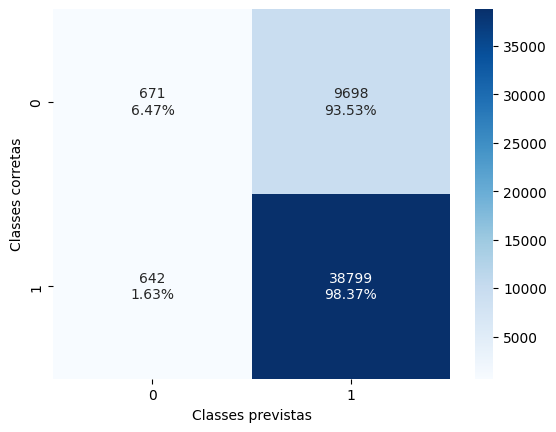

In [13]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(y_test, pipeline.predict(X_test)))

In [14]:
with open('./app/model.pkl', 'rb') as file:
  old_model = pickle.load(file)

In [15]:
roc_auc_score(y_test, old_model.predict_proba(X_test)[:, 1])

0.6075332746684731

<Axes: xlabel='Classes previstas', ylabel='Classes corretas'>

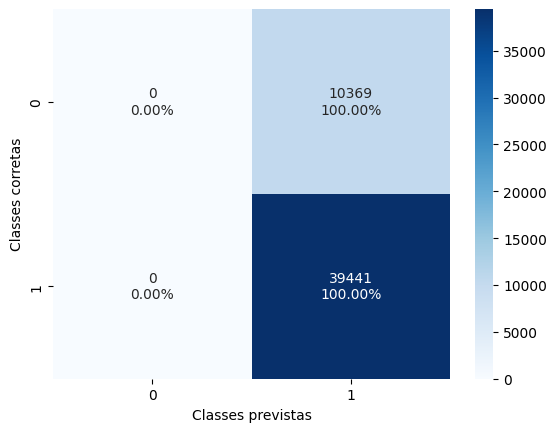

In [16]:
plot_confusion_matrix(confusion_matrix(y_test, old_model.predict(X_test)))

## Salvando modelo
Como de fato o modelo utilizando o algoritmo XGBoost performou melhor que àquele fornecido nas métricas escolhidas para avaliação, salvamos o resultado e utilizamos na API.

In [ ]:
with open('./app/xgb_model.pkl', 'wb') as file:
  pickle.dump(pipeline, file)